In [1]:
import glob
import os
from typing import List, Tuple, Optional, Dict
import pickle
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from flwr.common import Metrics
from omegaconf import DictConfig
from flwr.server.history import History
from dataset import *
from torch.utils.data import Sampler, RandomSampler
# from sklearn.model_selection import train_test_split
# from torch.utils.data import Dataset, Subset

In [2]:
datapath = 'D:/DesktopC/Datasets/data/'
subset = True #True
num_classes = 4
num_workers = 1
batch_size=64
seed=2024
num_partitions = 10
alpha = 0.5
# partitioning = 'dirichlet' 
partitioning = 'iid'
val_ratio = 0.1

In [3]:
trf = Compose([
        Resize_with_pad(),
        ToTensor(),
])
trainset, testset = get_food101(trf, datapath, subset, num_classes)

In [4]:
print(type(trainset))
print(len(trainset.indices))
print(len(trainset.labels))
print(trainset.indices)
print(trainset.labels)
# tmp_lab = [lab for _,lab in trainset.__getitem__([trainset.indices])]

<class 'dataset.CustomSubset'>
3000
3000
[12750 12751 12752 ... 45747 45748 45749]
[0 0 0 ... 3 3 3]


In [26]:
# balanced classes & IID
# partitioning_iid(trainset, num_partitions, balance, seed)
# split trainset into `num_partitions` trainsets (one per client)
# figure out number of training examples per partition
num_images = len(trainset) // num_partitions
# a list of partition lengths (all partitions are of equal size)
partition_len = [num_images] * num_partitions

# idxs dict -> Client ID : Client's indexes
idxs_map = {}
# range sequence indices
idxs = np.array(range(len(trainset.indices)))
# get the targets
tmp_t = trainset.labels
# unique labels
num_classes = len(set(tmp_t))
idx_for_each_class = []
for i in range(num_classes):
    idx_for_each_class.append(idxs[tmp_t == i])
# every client has the same classes
class_num_per_client = [num_classes for _ in range(num_partitions)]
for i in range(num_classes):
    selected_clients = []
    for client in range(num_partitions):
        if class_num_per_client[client] > 0:
            selected_clients.append(client)
    selected_clients = selected_clients[:int(np.ceil((num_partitions / num_classes) * num_classes))]

    num_all_samples = len(idx_for_each_class[i])
    num_selected_clients = len(selected_clients)
    num_per = num_all_samples / num_selected_clients
    # fair balanced split
    num_samples = [int(num_per) for _ in range(num_selected_clients-1)]
    num_samples.append(num_all_samples-sum(num_samples))
    idx = 0
    for client, num_sample in zip(selected_clients, num_samples):
        if client not in idxs_map.keys():
            idxs_map[client] = idx_for_each_class[i][idx:idx+num_sample]
        else:
            idxs_map[client] = np.append(idxs_map[client], idx_for_each_class[i][idx:idx+num_sample], axis=0)
        idx += num_sample
        class_num_per_client[client] -= 1

# range sequence indices into dataset indices reference
idxs_map = [trainset.indices[idxs_map[client]] for client in range(len(idxs_map))]
# assign custom trainsets
trainsets = [CustomSubset(trainset.dataset, idxs_map[i]) for i in range(len(idxs_map))]


5.0


In [5]:
## IID Sampling 
# split trainset into `num_partitions` trainsets (one per client)
# figure out number of training examples per partition
num_images = len(trainset) // num_partitions
# a list of partition lengths (all partitions are of equal size)
partition_len = [num_images] * num_partitions
idxs = list(range(len(trainset.indices)))
np.random.seed(seed)
np.random.shuffle(idxs)
trainsets_idx = [idxs[id*p_len:(id+1)*p_len] for id,p_len in enumerate(partition_len)]
idxs_map = trainset.indices[trainsets_idx]
trainsets = [CustomSubset(trainset.dataset, idxs_map[i]) for i in range(len(idxs_map))]

In [8]:
# print(trainsets[0].indices)
# print(trainsets[0].labels)
print(testset.labels)
print(len(testset.labels))

[92 92 92 92 92 92 92 92 92 92 92 92 92 92 92 92 92 92 92 92 92 92 92 92
 92 92 92 92 92 92 92 92 92 92 92 92 92 92 92 92 92 92 92 92 92 92 92 92
 92 92 92 92 92 92 92 92 92 92 92 92 92 92 92 92 92 92 92 92 92 92 92 92
 92 92 92 92 92 92 92 92 92 92 92 92 92 92 92 92 92 92 92 92 92 92 92 92
 92 92 92 92 92 92 92 92 92 92 92 92 92 92 92 92 92 92 92 92 92 92 92 92
 92 92 92 92 92 92 92 92 92 92 92 92 92 92 92 92 92 92 92 92 92 92 92 92
 92 92 92 92 92 92 92 92 92 92 92 92 92 92 92 92 92 92 92 92 92 92 92 92
 92 92 92 92 92 92 92 92 92 92 92 92 92 92 92 92 92 92 92 92 92 92 92 92
 92 92 92 92 92 92 92 92 92 92 92 92 92 92 92 92 92 92 92 92 92 92 92 92
 92 92 92 92 92 92 92 92 92 92 92 92 92 92 92 92 92 92 92 92 92 92 92 92
 92 92 92 92 92 92 92 92 92 92  4  4  4  4  4  4  4  4  4  4  4  4  4  4
  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4
  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4
  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4

In [7]:
# print(len(trainset))
# print(num_images)
# print(partition_len)
# print(idxs)
# print(trainset.indices[:30])
# print(trainsets_idx)
# c_id_mapper = trainset.indices[trainsets_idx[0]]
# print(c_id_mapper)
print(idxs_map)
for i in range(num_partitions):
    print(trainsets_idx[i])

# print(len(idx_clients))
for i in range(num_partitions):
    # print(idx_clients[i])
    # print(len(idx_clients[i]))
    # print(len(trainsets_dir[i]))
    print(trainsets_dir[i].labels)
    # print(idxs_map[i])

# trainset.dataset.
# # tmp_imgs, tmp_labels = [trainset.__getitem__(id) for id in idxs]
# # print(trainset.__getitem__(3))
# for _, train_data in enumerate(trainset, 0):

[[13046 17247 13430 ... 45290 29977 45111]
 [16883 13183 45352 ... 29355 29765 29792]
 [29428 29514 12770 ... 29272 13198 13285]
 ...
 [29637 29736 13274 ... 16756 13384 45549]
 [45094 45517 29333 ... 16534 29493 12859]
 [16780 45573 17144 ... 45337 45438 45406]]
[296, 1497, 680, 840, 1359, 2142, 346, 666, 844, 754, 86, 1906, 1396, 401, 1365, 2154, 501, 775, 964, 1869, 1611, 1002, 943, 2815, 230, 711, 873, 2882, 1427, 2947, 472, 1453, 2741, 1464, 659, 1655, 2214, 2620, 1955, 2328, 951, 2122, 1381, 717, 1337, 786, 1915, 2113, 2853, 2047, 192, 2010, 1102, 163, 1831, 1235, 2577, 1934, 348, 1429, 2077, 646, 2189, 2989, 1885, 2941, 1647, 572, 2329, 1342, 1940, 8, 1926, 2467, 2704, 1389, 355, 1787, 1642, 1677, 2472, 2753, 1863, 2117, 171, 344, 1645, 2790, 2820, 2249, 2084, 1347, 1189, 416, 2913, 2459, 1508, 896, 938, 2030, 1538, 1248, 1357, 1965, 2750, 6, 2869, 616, 2632, 2554, 460, 2103, 2401, 2535, 2014, 2726, 125, 690, 639, 2960, 2162, 1728, 960, 276, 1721, 790, 1363, 404, 445, 279, 1293,

NameError: name 'trainsets_dir' is not defined

In [9]:
#TBD: dirichlet, plotting through trainsets, train+val support, dataloaders and samplers
# DIRICHLET SAMPLING
min_required_samples_per_client = 10
min_samples = 0
prng = np.random.default_rng(seed)

# get the targets
tmp_t = trainset.labels
# tmp_t = trainset.targets
if isinstance(tmp_t, list):
    tmp_t = np.array(tmp_t)
if isinstance(tmp_t, torch.Tensor):
    tmp_t = tmp_t.numpy()
num_classes = len(set(tmp_t))
total_samples = len(tmp_t)
while min_samples < min_required_samples_per_client:
    idx_clients: List[List] = [[] for _ in range(num_partitions)]
    for k in range(num_classes):
        idx_k = np.where(tmp_t == k)[0]
        prng.shuffle(idx_k)
        proportions = prng.dirichlet(np.repeat(alpha, num_partitions))
        # balancing
        proportions = np.array(
            [
                p * (len(idx_j) < total_samples / num_partitions)
                for p, idx_j in zip(proportions, idx_clients)
            ]
        )
        proportions = proportions / proportions.sum()
        proportions = (np.cumsum(proportions) * len(idx_k)).astype(int)[:-1]
        idx_k_split = np.split(idx_k, proportions)
        idx_clients = [
            idx_j + idx.tolist() for idx_j, idx in zip(idx_clients, idx_k_split)
        ]
        min_samples = min([len(idx_j) for idx_j in idx_clients])

idxs_map = [trainset.indices[idx_clients[i]] for i in range(num_partitions)]
trainsets_dir = [CustomSubset(trainset.dataset, idxs_map[i]) for i in range(len(idxs_map))] 

In [10]:
print(trainsets_dir)
print(trainsets)

[<dataset.CustomSubset object at 0x0000021D66DB71D0>, <dataset.CustomSubset object at 0x0000021D68E64550>, <dataset.CustomSubset object at 0x0000021D68E645D0>, <dataset.CustomSubset object at 0x0000021D68E67E50>, <dataset.CustomSubset object at 0x0000021D68E65090>, <dataset.CustomSubset object at 0x0000021D68E66C10>, <dataset.CustomSubset object at 0x0000021D68E67790>, <dataset.CustomSubset object at 0x0000021D68E67590>, <dataset.CustomSubset object at 0x0000021D68E66650>, <dataset.CustomSubset object at 0x0000021D68E66750>]
[<dataset.CustomSubset object at 0x0000021D6691E510>, <dataset.CustomSubset object at 0x0000021D65580DD0>, <dataset.CustomSubset object at 0x0000021D58B59990>, <dataset.CustomSubset object at 0x0000021D66911F90>, <dataset.CustomSubset object at 0x0000021D66912190>, <dataset.CustomSubset object at 0x0000021D66912150>, <dataset.CustomSubset object at 0x0000021D66912250>, <dataset.CustomSubset object at 0x0000021D669121D0>, <dataset.CustomSubset object at 0x0000021D66

In [261]:
# https://numpy.org/doc/stable/reference/random/generated/numpy.random.dirichlet.html
# plt.barh()
def get_subset_stats(sub_trainset: CustomSubset):
    unq, unq_count = np.unique(sub_trainset.labels, return_counts=True)
    tmp = {int(unq[i]) : int(unq_count[i]) for i in range(len(unq))}
    return tmp

def plot_exp_summary(trainsets: list[CustomSubset], title_str: str, num_classes: int, save_str: str):
    for c_id, sub_trainset in enumerate(trainsets):
        tmp = get_subset_stats(sub_trainset)
        classes = list(tmp.keys())
        counter = list(tmp.values())
        dy = list(range(len(classes)))
        dx = [c_id] * len(classes)
        plt.scatter(dx, dy, s = counter)
    plt.xticks(range(len(trainsets)))
    plt.xlabel('Client')
    plt.yticks(range(num_classes))
    plt.ylabel('Class')
    plt.title(title_str)
    plt.savefig(save_str)
    plt.close()

def plot_client_stats(partitioning: str, id: int, tmp: dict, num_classes: int, save_str_cid):
    x = list(tmp.keys())
    y = list(tmp.values())
    fig = plt.figure()
    ax1 = fig.add_subplot()
    ax1.set_ylabel('Frequency')
    ax1.set_xlabel('Class')
    ax1.set_title(f"Client {id} with {sum(y)} data samples")
    ax1.set_xticks(x) #label_tags[x], rotation=90)
    # ax1.set_xticklabels(labels=label_tags)
    ax1.set_yticks(y)
    ax1.bar(x,y, width=0.1)
    fig.savefig(f"images/clients_vis/{partitioning}/{id}_cid{save_str_cid}_classes_{num_classes}_summary.png")
    plt.close()

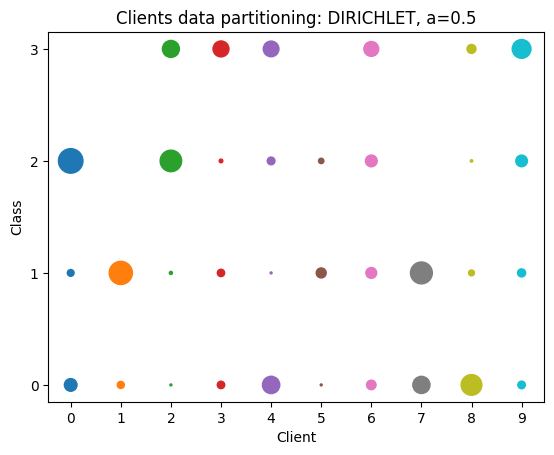

In [262]:
#PLOTTING TRAINSETS
partitioning='dirichlet'
title_str = f"Clients data partitioning: {partitioning.upper()}, a={alpha}"
save_str_exp = f"images/clients_vis/{partitioning}/alpha_{alpha}_clients_{len(trainsets)}_classes_{num_classes}_summary.png"
save_str_cid: str = (f"_a_{alpha}")
if not os.path.exists(f'./images/clients_vis/{partitioning}/'):
            os.makedirs(f'./images/clients_vis/{partitioning}/')
plot_exp_summary(trainsets_dir, title_str, num_classes, save_str_exp)
for c_id, sub_trainset in enumerate(trainsets_dir):
        tmp = get_subset_stats(sub_trainset)
        plot_client_stats(partitioning, c_id+1, tmp, num_classes, save_str_cid)


In [263]:
# TRAIN+VAL SUPPORT
print(trainsets_dir)
print(trainsets)
# print(trainsets[0].indices)
# print(trainsets_dir[0].indices)
# idxs_map = [trainset.indices[idx_clients[i]] for i in range(num_partitions)]
# trainsets_dir = [CustomSubset(trainset.dataset, idxs_map[i]) for i in range(len(idxs_map))] 
# print(trainsets_dir[0].labels)


[<dataset.CustomSubset object at 0x0000027A81334090>, <dataset.CustomSubset object at 0x0000027A928EE1D0>, <dataset.CustomSubset object at 0x0000027A93383590>, <dataset.CustomSubset object at 0x0000027A911AE490>, <dataset.CustomSubset object at 0x0000027A92CE1510>, <dataset.CustomSubset object at 0x0000027A911FB790>, <dataset.CustomSubset object at 0x0000027A811E3710>, <dataset.CustomSubset object at 0x0000027A8E6A1A50>, <dataset.CustomSubset object at 0x0000027A8E6A2F50>, <dataset.CustomSubset object at 0x0000027A92CE00D0>]
[<dataset.CustomSubset object at 0x0000027A8BA0A510>, <dataset.CustomSubset object at 0x0000027A935063D0>, <dataset.CustomSubset object at 0x0000027A92823A50>, <dataset.CustomSubset object at 0x0000027A844FAB90>, <dataset.CustomSubset object at 0x0000027A8C588F90>, <dataset.CustomSubset object at 0x0000027A906DD450>, <dataset.CustomSubset object at 0x0000027A928B08D0>, <dataset.CustomSubset object at 0x0000027A906DC2D0>, <dataset.CustomSubset object at 0x0000027A90

In [11]:
# idxs_tr = 
trainloaders: list[CustomSubset] = []
valloaders: list[CustomSubset] = []
np.random.seed(seed)
for trainset_ in trainsets:
    num_total = len(trainset_)
    num_val = int(val_ratio * num_total)
    num_train = num_total - num_val
    # trainsets on IID case are already shuffled
    # choose validation indexes
    choices = np.random.choice(range(num_total), size=num_val, replace=False)
    # boolean split
    idxs_val = np.zeros(num_total, dtype=bool)
    idxs_val[choices] = True
    idxs_tr = ~idxs_val
    trainloaders.append(CustomSubset(trainset_.dataset, trainset_.indices[idxs_tr]))
    valloaders.append(CustomSubset(trainset_.dataset, trainset_.indices[idxs_val]))
    print(trainset_.indices[idxs_tr])
    # print(idxs_val)
    # print(idxs_val)
    print(idxs_tr)

[17247 16590 17109 29892 13096 13416 16594 12836 29656 17146 13151 17115
 29904 13251 16525 16714 29619 29361 16693 45565 12980 13461 16623 45632
 17177 45697 13222 17203 45491 13409 29405 29964 45370 29705 45078 16701
 29872 17131 13467 17087 16536 29863 45603 29797 12942 29760 16852 12913
 29581 16985 45327 29684 13098 17179 29827 13396 29939 45739 29635 45691
 29397 13322 45079 17092 29690 12758 45217 45454 17139 13105 29537 29392
 45503 29613 29867 12921 13094 29395 45540 45570 29999 29834 17097 16939
 13166 45663 45209 29258 16646 16688 29288 16998 17107 29715 45500 12756
 45619 13366 45382 45304 13210 29853 45151 45285 29764 45476 12875 13440
 13389 45710 29912 29478 16710 13026 29471 13154 13195 13029 17043 13051
 29597 29917 16744 12869 29290 17187 13443 45631 12821 45044 16698 29762
 13426 45118 45742 17168 12876 13136 45068 45512 45311 29682 29861 12766
 12955 29305 45274 16924 13257 16627 29948 45698 45318 13310 45441 13252
 29657 45471 17242 45091 12751 29525 45317 12956 12

In [12]:
# reproducable shuffling for training
torch.manual_seed(seed)
G = torch.Generator()
G.manual_seed(seed)
idxs_map = [trainset.indices[idx_clients[i]] for i in range(num_partitions)]
trainsets_dir = [CustomSubset(trainset.dataset, idxs_map[i]) for i in range(len(idxs_map))] 
# construct sets
data_trainloaders = [DataLoader(Subset(trainloaders[i].dataset, trainloaders[i].indices), batch_size=batch_size, shuffle=True, generator=G) for i in range(len(trainloaders))]
print(data_trainloaders)
print(data_trainloaders[0])
for data in data_trainloaders[9]:
    print(data)
    break


[<torch.utils.data.dataloader.DataLoader object at 0x0000021D6691FA10>, <torch.utils.data.dataloader.DataLoader object at 0x0000021D66DA2B90>, <torch.utils.data.dataloader.DataLoader object at 0x0000021D68E644D0>, <torch.utils.data.dataloader.DataLoader object at 0x0000021D68E67710>, <torch.utils.data.dataloader.DataLoader object at 0x0000021D68E67150>, <torch.utils.data.dataloader.DataLoader object at 0x0000021D68E65610>, <torch.utils.data.dataloader.DataLoader object at 0x0000021D68E64190>, <torch.utils.data.dataloader.DataLoader object at 0x0000021D68E64350>, <torch.utils.data.dataloader.DataLoader object at 0x0000021D68E65F90>, <torch.utils.data.dataloader.DataLoader object at 0x0000021D68E651D0>]
[tensor([[[[0.0549, 0.0510, 0.0510,  ..., 0.0667, 0.0706, 0.0667],
          [0.0588, 0.0549, 0.0549,  ..., 0.0902, 0.0941, 0.0863],
          [0.0627, 0.0588, 0.0549,  ..., 0.1059, 0.1059, 0.0980],
          ...,
          [0.0314, 0.0275, 0.0275,  ..., 0.0314, 0.0431, 0.0510],
         

In [14]:
testloader = DataLoader(Subset(testset.dataset, testset.indices), batch_size=batch_size, num_workers=num_workers)
for data in testloader:
    print(data)
    break

[tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 

In [226]:
load_dataset()

5


In [ ]:
# create dataloaders with train+val support
trainloaders = []
valloaders = []
for trainset_ in trainsets:
    num_total = len(trainset_)
    num_val = int(val_ratio * num_total)
    num_train = num_total - num_val

    for_train, for_val = random_split(trainset_, [num_train, num_val], torch.Generator().manual_seed(seed))
    # construct data loaders and append to their respective list.
    # In this way, the i-th client will get the i-th element in the trainloaders list and the i-th element in the valloaders list
    trainloaders.append(DataLoader(for_train, batch_size=batch_size, shuffle=True, num_workers=num_workers))
    valloaders.append(DataLoader(for_val, batch_size=batch_size, shuffle=True, num_workers=num_workers))

testloader = DataLoader(testset, batch_size=batch_size, num_workers=num_workers)
# return trainloaders, valloaders, testloader

In [ ]:
if partitioning == "iid":
    trainsets = partitioning_iid(trainset, num_partitions, seed)
    title_str = f"Clients data partioning: {partitioning.upper()}"
elif partitioning == "dirichlet":
    trainsets = partitioning_dirichlet(alpha, trainset, num_partitions, seed)
    title_str = f"Clients data partioning: {partitioning.upper()}, a={alpha}"
else:
    raise ValueError

In [107]:
# trainloaders, testloader = load_centr_data(datapath=datapath, subset=subset, num_classes=num_classes, num_workers=num_workers, batch_size=batch_size)
trf = Compose([
        Resize_with_pad(),
        ToTensor(),
])
trainset, testset = get_food101(trf, datapath, subset, num_classes)
if partitioning == "iid":
    trainsets = partitioning_iid(trainset, num_partitions, seed)
    title_str = f"Clients data partioning: {partitioning.upper()}"
elif partitioning == "dirichlet":
    trainsets = partitioning_dirichlet(alpha, trainset, num_partitions, seed)
    title_str = f"Clients data partioning: {partitioning.upper()}, a={alpha}"
else:
    raise ValueError

# create dataloaders with train+val support
trainloaders = []
valloaders = []
for trainset_ in trainsets:
    num_total = len(trainset_)
    num_val = int(val_ratio * num_total)
    num_train = num_total - num_val

    for_train, for_val = random_split(trainset_, [num_train, num_val], torch.Generator().manual_seed(seed))
    trainloaders.append(for_train)
    valloaders.append(for_val)


In [32]:
def get_subset_stats(sub_trainset: Subset):
    active_labels = [label for _,label in sub_trainset]
    unq, unq_count = np.unique(active_labels, return_counts=True)
    tmp = {int(unq[i]) : int(unq_count[i]) for i in range(len(unq))}
    return tmp

def plot_client_stats(label_tags: list[str], partitioning: str, id: int, tmp: dict):
    x = list(tmp.keys())
    y = list(tmp.values())
    fig = plt.figure()
    ax1 = fig.add_subplot()
    ax1.set_ylabel('Frequency')
    ax1.set_xlabel('Class')
    ax1.set_title(f"Client {id} with {sum(y)} data samples")
    ax1.set_xticks(x, label_tags) # rotation=90)
    # ax1.set_xticklabels(labels=label_tags)
    ax1.set_yticks(y)
    ax1.bar(x,y)
    fig.savefig(f"images/clients_vis/{partitioning}/{id}_clients_data.png")
    plt.close()
    # if not os.path.exists(f'./images/clients_vis/{partitioning}/'):
    #         os.makedirs(f'./images/clients_vis/{partitioning}/')
    

# Trainsets visualisation
# label_tags = list(trainset.dataset.__dict__["class_to_idx"].keys())[:num_classes]

# for i, sub_trainset in enumerate(trainloaders):
#     tmp = get_subset_stats(sub_trainset)
#     plot_client_stats(label_tags, partitioning, i+1, tmp)

# fig, ax= plt.plot()

return 0
    

KeyboardInterrupt: 

In [109]:
# trainset.__getitem__(3)
transform = Compose([
         Resize_with_pad(),
         ToTensor(),
    ])
trainset = Food101(root=datapath, split="train", transform=transform, download= True)
#Taking Subset of trainset and testset
# select classes you want to include in your subset
list = [i for i in range(num_classes)]
classes = torch.tensor(list)
# classes = torch.tensor([0, 1, 2, 3])
# get indices that correspond to one of the selected classes
train_indices = (torch.tensor(trainset._labels)[..., None] == classes).any(-1).nonzero(as_tuple=True)[0]

# subset the dataset
train_sub = Subset(trainset, train_indices)
print(len(train_sub.indices))
print(classes)
print(trainset._labels)

np_tr_lab = np.array(trainset._labels)
np_tr_idx = np.array(train_indices)
mapped_lab = np_tr_lab[np_tr_idx]
print(len(np_tr_lab))
print(len(mapped_lab))
print(mapped_lab)
print(np_tr_lab)
print(np_tr_idx)

3000
tensor([0, 1, 2, 3])
[23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 2

In [112]:
sub_train_dataset = CustomSubset(trainset, np_tr_idx, np_tr_lab)
sub_train_datasets = partitioning_iid(sub_train_dataset, num_partitions, seed)
print(sub_train_datasets)
# for i in range(num_partitions):
#     print(len(sub_train_datasets[i].indices))

def get_subset_stats(sub_trainset):
    # active_labels = [label for _,label in sub_trainset]
    active_labels = sub_trainset.labels
    unq, unq_count = np.unique(active_labels, return_counts=True)
    tmp = {int(unq[i]) : int(unq_count[i]) for i in range(len(unq))}
    return tmp

for c_id, sub_trainset in enumerate(sub_train_datasets):
    tmp = get_subset_stats(sub_trainset)
    classes = list(tmp.keys())
    counter = list(tmp.values())
    dy = list(range(len(classes)))
    dx = [c_id] * len(classes)
    plt.scatter(dx, dy, s = counter)
plt.xticks(range(num_partitions))
plt.xlabel('Client')
plt.yticks(range(num_classes))
plt.ylabel('Class')
plt.title(title_str)
# tmp_trainld = DataLoader(sub_train_dataset, shuffle=True, batch_size=32)

[<torch.utils.data.dataset.Subset object at 0x000001933A491250>, <torch.utils.data.dataset.Subset object at 0x000001933AC9E110>, <torch.utils.data.dataset.Subset object at 0x000001934527A090>, <torch.utils.data.dataset.Subset object at 0x0000019345279790>, <torch.utils.data.dataset.Subset object at 0x0000019345279E90>, <torch.utils.data.dataset.Subset object at 0x0000019345279D10>, <torch.utils.data.dataset.Subset object at 0x0000019345279ED0>, <torch.utils.data.dataset.Subset object at 0x0000019345279DD0>, <torch.utils.data.dataset.Subset object at 0x000001934527A7D0>, <torch.utils.data.dataset.Subset object at 0x0000019345279A90>]


AttributeError: 'Subset' object has no attribute 'labels'

array([12750, 12751, 12752, ..., 45747, 45748, 45749], dtype=int64)

In [ ]:
# ncols
ncols = 3
# nrows
nrows = num_partitions // ncols + (num_partitions % ncols > 0)
print(f"Plotting stats for {num_partitions} clients population")
fig1 = plt.figure() #figsize=(15,15)
plt.subplots_adjust(hspace=0.5)
for i, sub_trainset in enumerate(trainloaders):
    tmp = get_subset_stats(sub_trainset)
    plot_client_stats(label_tags, partitioning, i+1, tmp)
    x = list(tmp.keys())
    y = list(tmp.values())
    ax1 = fig1.add_subplot(nrows, ncols, i+1)
    ax1.set_ylabel('Frequency')
    ax1.set_xlabel('Class')
    ax1.set_title(f"Client {i+1} data")
    ax1.set_xticks(x)
    ax1.set_xticklabels(labels=label_tags)
    ax1.set_yticks(y)
    ax1.bar(x,y)
    plt.show()
    
# trainset.dataset.targets
sub_trainset: Subset =  trainloaders[0]
print(len(sub_trainset.indices))
subsets_size = np.sum([len(s_tr) for s_tr in trainloaders])
print(subsets_size)
# for s_trainset in trainloaders:
#     print(len(s_trainset))
for i, (image, label) in enumerate(sub_trainset):
    print(label)
    break
    # if i == 50:
    #     break
    
trainset.dataset.__dict__["classes"][:num_classes]
# class_names = 
# print(trainset.dataset.__dict__["class_to_idx"].items().keys()[1])
# classes_names = [k for k,v in trainset.dataset.__dict__["class_to_idx"].items() break if v == num_classes]
print()
for k,v in trainset.dataset.__dict__["class_to_idx"].items():
    print(k)
    print(v)
    break
    if v == num_classes:
        break
print(len(trainset.dataset.__dict__["_labels"]))
# np.unique()
# trainset.dataset.__dict__["class_to_idx"]
# trainset.indices[sub_trainset.indices]
# trainset.dataset
# sub_trainset.dataset

In [38]:
trainloaders, testloader = load_centr_data(datapath=datapath,subset=subset,num_classes=num_classes,num_workers=num_workers,batch_size=batch_size)

Loading data...


In [39]:
testloader.targets

AttributeError: 'DataLoader' object has no attribute 'targets'

In [9]:
accuracy = 5
accuracies = [i for i in range(1,10)]
test2 = [p for p in range(1,10)]
# print(accuracies/test2)
print(accuracy)
print(accuracies)
abs_diff_acc = np.array(accuracies) - accuracy
print(abs_diff_acc)
print(np.mean(accuracies))
print(np.mean(abs_diff_acc))
type(abs_diff_acc)

5
[1, 2, 3, 4, 5, 6, 7, 8, 9]
[-4 -3 -2 -1  0  1  2  3  4]
5.0
0.0


numpy.ndarray

In [30]:
import torch
import numpy as np
import torchvision.datasets as datasets
from torchvision import transforms
import torchvision.transforms.functional as F
datapath = 'D:/DesktopC/Datasets/data/'
# transforms.Pad()
class SquarePad:
	def __call__(self, image):
		w, h = image.size
		max_wh = np.max([w, h])
		hp = int((max_wh - w) / 2)
		vp = int((max_wh - h) / 2)
		padding = (hp, vp, hp, vp)
		return F.pad(image, padding, 0, 'constant')

class Resize_with_pad:
    def __init__(self, w=512, h=512):
        self.w = w
        self.h = h

    def __call__(self, image):

        w_1, h_1 = image.size
        ratio_f = self.w / self.h
        ratio_1 = w_1 / h_1


        # check if the original and final aspect ratios are the same within a margin
        if round(ratio_1, 2) != round(ratio_f, 2):

            # padding to preserve aspect ratio
            hp = int(w_1/ratio_f - h_1)
            wp = int(ratio_f * h_1 - w_1)
            if hp > 0 and wp < 0:
                hp = hp // 2
                image = F.pad(image, (0, hp, 0, hp), 0, "constant")
                return F.resize(image, [self.h, self.w])

            elif hp < 0 and wp > 0:
                wp = wp // 2
                image = F.pad(image, (wp, 0, wp, 0), 0, "constant")
                return F.resize(image, [self.h, self.w])

        else:
            return F.resize(image, [self.h, self.w])

trf2 = transforms.Compose([
	    # SquarePad(),
        Resize_with_pad(),
        transforms.ToTensor(),
		# transforms.Resize((512,512)),
        # transforms.Pad(padding=padding),
        # Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
# trf = 
trainset = datasets.Food101(root=datapath, split="train", transform=trf2, download= True)
testset = datasets.Food101(root=datapath, split="test", transform=trf2, download= True)



In [31]:
type(trainset)
print(trainset.classes)

['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare', 'beet_salad', 'beignets', 'bibimbap', 'bread_pudding', 'breakfast_burrito', 'bruschetta', 'caesar_salad', 'cannoli', 'caprese_salad', 'carrot_cake', 'ceviche', 'cheese_plate', 'cheesecake', 'chicken_curry', 'chicken_quesadilla', 'chicken_wings', 'chocolate_cake', 'chocolate_mousse', 'churros', 'clam_chowder', 'club_sandwich', 'crab_cakes', 'creme_brulee', 'croque_madame', 'cup_cakes', 'deviled_eggs', 'donuts', 'dumplings', 'edamame', 'eggs_benedict', 'escargots', 'falafel', 'filet_mignon', 'fish_and_chips', 'foie_gras', 'french_fries', 'french_onion_soup', 'french_toast', 'fried_calamari', 'fried_rice', 'frozen_yogurt', 'garlic_bread', 'gnocchi', 'greek_salad', 'grilled_cheese_sandwich', 'grilled_salmon', 'guacamole', 'gyoza', 'hamburger', 'hot_and_sour_soup', 'hot_dog', 'huevos_rancheros', 'hummus', 'ice_cream', 'lasagna', 'lobster_bisque', 'lobster_roll_sandwich', 'macaroni_and_cheese', 'macarons', 'miso_sou

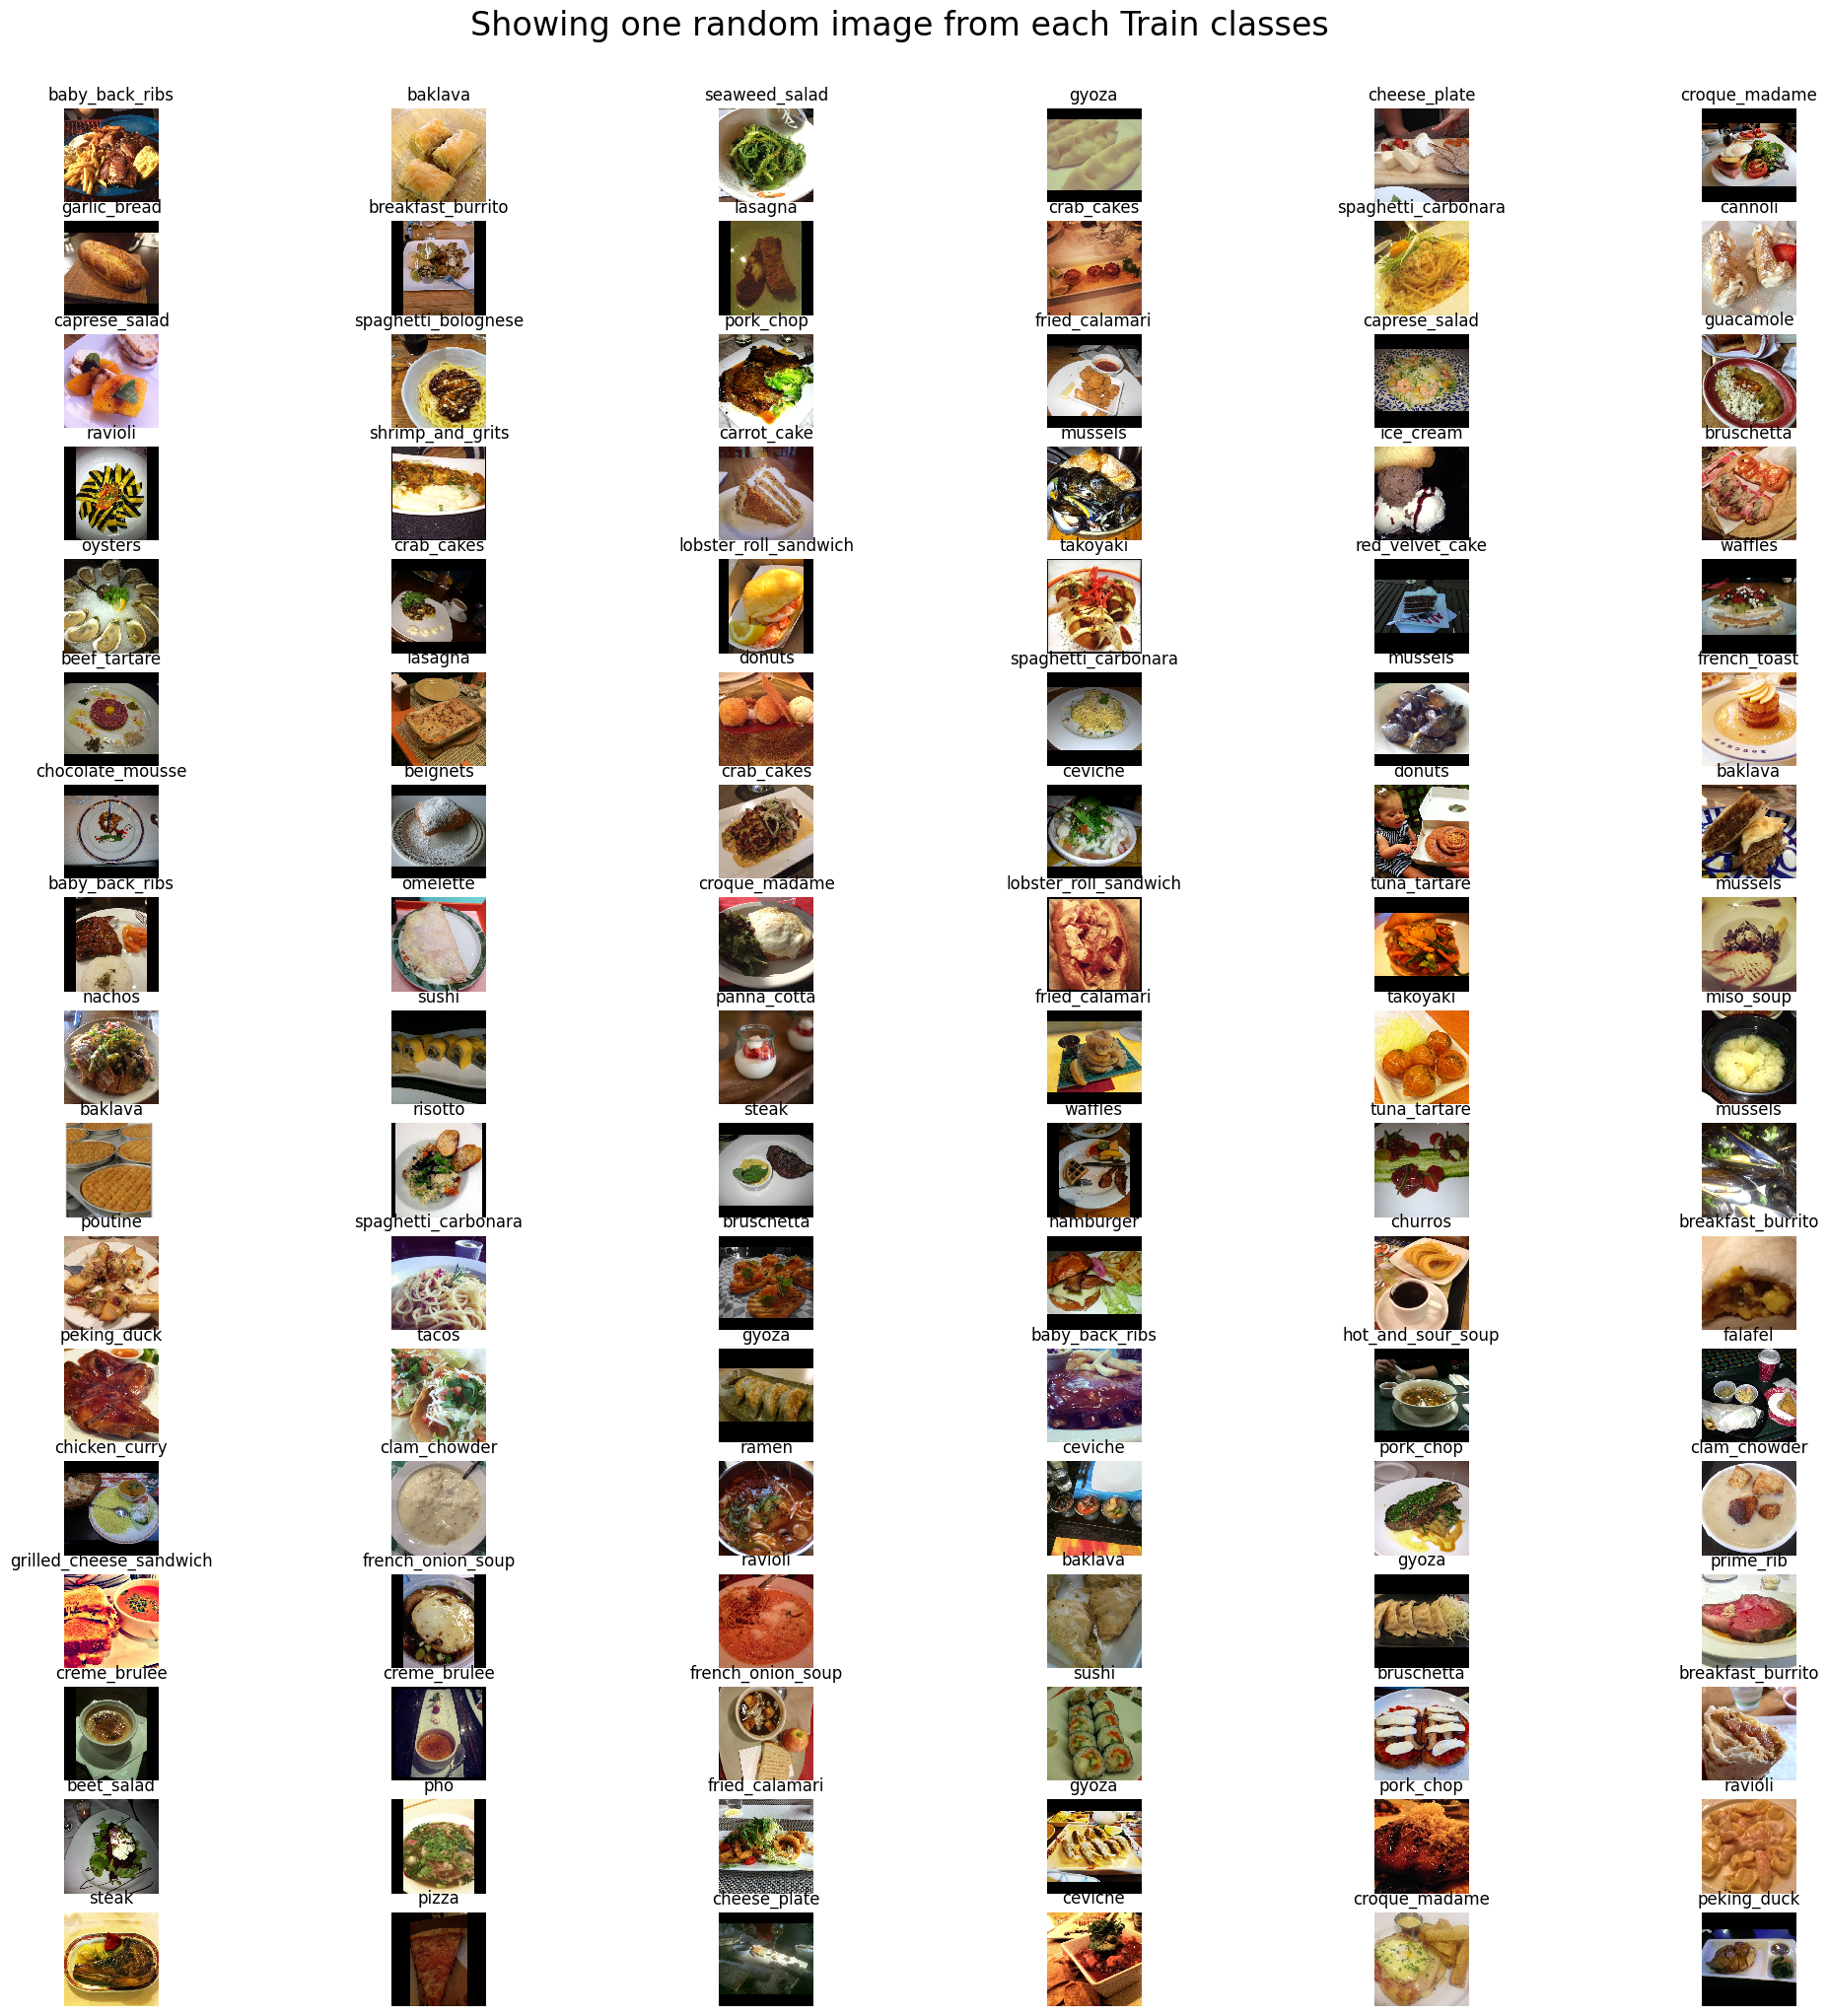

In [32]:
# This can be used to print predictions too
imagenet_stats = [(0.485, 0.456, 0.406), (0.229, 0.224, 0.225)]

def show_ds(trainset, classes, validset=None, cols=6, rows=17, preds=None, is_pred=False, is_valid=False):        
    fig = plt.figure(figsize=(25,25))
    fig.suptitle(f"Showing one random image from each {'Validation' if is_valid else 'Train'} classes", y=0.92, fontsize=24) # Adding  y=1.05, fontsize=24 helped me fix the suptitle overlapping with axes issue
    columns = cols
    rows = rows
    imgenet_mean = imagenet_stats[0]
    imgenet_std = imagenet_stats[1]  

    for i in range(1, columns*rows +1):
        fig.add_subplot(rows, columns, i)
        
        if is_pred and testset:
            img_xy = np.random.randint(len(testset));
            np_img = testset[img_xy][0].numpy()
            img = np.transpose(np_img, (1,2,0))            
            # img = img * imgenet_std + imgenet_mean
        else:
            img_xy = np.random.randint(len(trainset));
            np_img = trainset[img_xy][0].numpy()
            img = np.transpose(np_img, (1,2,0))
            # img = img * imgenet_std + imgenet_mean
        
        if is_pred:
            plt.title(classes[int(preds[img_xy])] + "/" + classes[testset[img_xy][1]])
        else:
            plt.title(classes[trainset[img_xy][1]])
        plt.axis('off')
        img = np.clip(img, 0, 1)
        plt.imshow(img, interpolation='nearest')
    plt.show()


show_ds(trainset, trainset.classes)

In [4]:
# # use np.concatenate to stick all the images together to form a 1600000 X 32 X 3 array
# x = np.concatenate([np.asarray(dataset[i][0]) for i in range(len(dataset))])

# # calculate the mean and std along the (0, 1) axes
# train_mean = np.mean(x, axis=(0, 1))
# train_std = np.std(x, axis=(0, 1))
# # the the mean and std
# print(train_mean, train_std)

: 

In [1]:
import torch
import numpy as np
import torchvision.datasets as datasets
from torchvision import transforms

datapath = 'D:/DesktopC/Datasets/data/'
trainset = datasets.Food101(root=datapath, split="train", transform=transforms.ToTensor(), download= True)

def food101_mean_std(trainset):
    imgs = [item[0] for item in trainset] # item[0] and item[1] are image and its label
    imgs = torch.stack(imgs, dim=0).numpy()

    # calculate mean over each channel (r,g,b)
    mean_r = imgs[:,0,:,:].mean()
    mean_g = imgs[:,1,:,:].mean()
    mean_b = imgs[:,2,:,:].mean()

    # calculate std over each channel (r,g,b)
    std_r = imgs[:,0,:,:].std()
    std_g = imgs[:,1,:,:].std()
    std_b = imgs[:,2,:,:].std()

    return mean_r, mean_g, mean_b, std_r, std_g, std_b


mean_r, mean_g, mean_b, std_r, std_g, std_b = food101_mean_std(trainset)
print(mean_r, mean_g, mean_b, std_r, std_g, std_b)

In [3]:
num_classes = 4
list = [i for i in range(num_classes)]
classes = torch.tensor(list)
classes1 = torch.tensor([0, 1, 2, 3])
print(classes)
print(classes1)
print(classes1 == classes)

tensor([0, 1, 2, 3])
tensor([0, 1, 2, 3])
tensor([True, True, True, True])
